In [5]:
!pip install mediapipe

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
!pip freeze > requirements.txt

Found 1303 images for Training


Extracting features for SvmFacialFeatureTrain.csv: 100%|██████████| 1303/1303 [03:40<00:00,  5.92it/s]


Saved features to SvmFacialFeatureTrain.csv
Found 333 images for Testing


Extracting features for SvmFacialFeatureTest.csv: 100%|██████████| 333/333 [00:52<00:00,  6.31it/s]


Saved features to SvmFacialFeatureTest.csv

[ Training Emotion Model - SVM (NO SMOTE) ]

Best Params (Emotion SVM): {'clf__C': 10, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}

  EVALUASI EMOSI: DATA TRAINING (Tanpa SMOTE)
Accuracy (TRAIN SVM): 1.0
              precision    recall  f1-score   support

        fear       1.00      1.00      1.00       153
   surprised       1.00      1.00      1.00       293
       angry       1.00      1.00      1.00       202
         sad       1.00      1.00      1.00       160
   disgusted       1.00      1.00      1.00       234
       happy       1.00      1.00      1.00       259

    accuracy                           1.00      1301
   macro avg       1.00      1.00      1.00      1301
weighted avg       1.00      1.00      1.00      1301



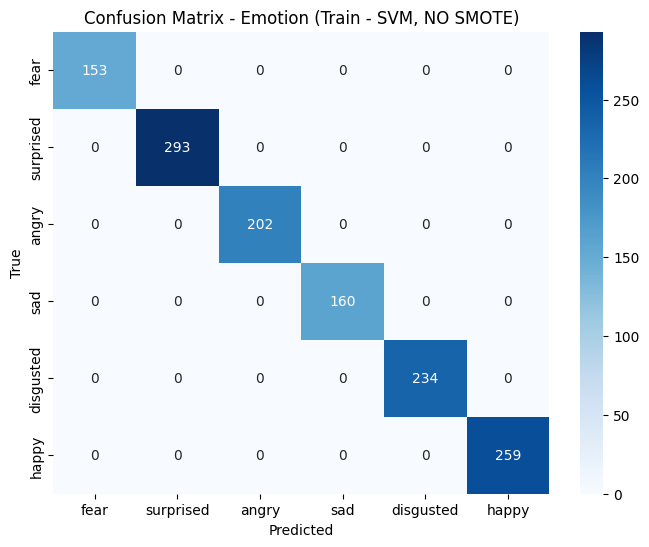


  EVALUASI EMOSI: DATA TESTING
Accuracy (TEST SVM): 0.8162650602409639
              precision    recall  f1-score   support

        fear       0.79      0.52      0.63        42
   surprised       0.92      0.91      0.91        76
       angry       0.83      0.81      0.82        67
         sad       0.48      0.70      0.57        23
   disgusted       0.74      0.83      0.78        58
       happy       0.94      0.94      0.94        66

    accuracy                           0.82       332
   macro avg       0.78      0.78      0.78       332
weighted avg       0.83      0.82      0.82       332



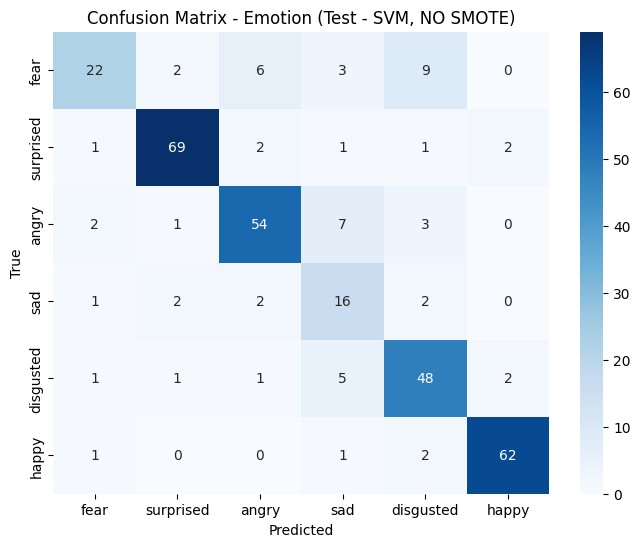


BERHASIL DISIMPAN: Model emosi disimpan di: BestSvmEmotionModel_LandTexNoSmote.joblib

[ Training Ethnicity Model - SVM ]

  EVALUASI ETNISITAS: DATA TRAINING
Accuracy (TRAIN SVM): 1.0
              precision    recall  f1-score   support

   Ambon (A)       1.00      1.00      1.00       197
  Toraja (T)       1.00      1.00      1.00       235
Kaukasia (K)       1.00      1.00      1.00       743
  Jepang (J)       1.00      1.00      1.00       126

    accuracy                           1.00      1301
   macro avg       1.00      1.00      1.00      1301
weighted avg       1.00      1.00      1.00      1301



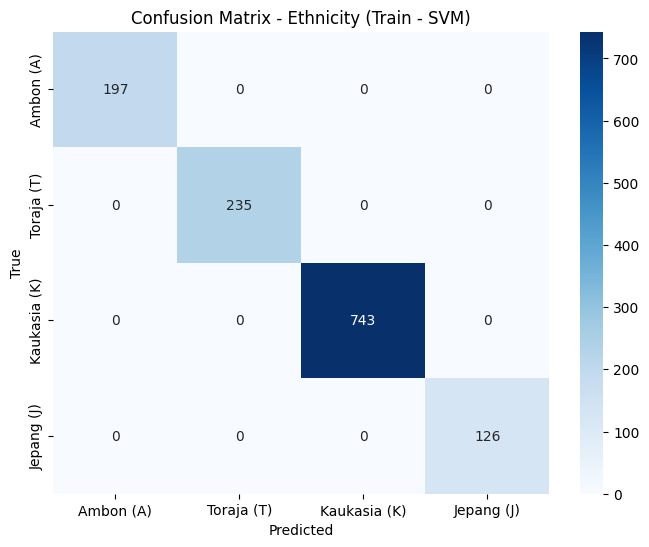


  EVALUASI ETNISITAS: DATA TESTING
Accuracy (TEST SVM): 0.963855421686747
              precision    recall  f1-score   support

   Ambon (A)       0.78      0.83      0.81        30
  Toraja (T)       0.91      0.88      0.90        59
Kaukasia (K)       1.00      1.00      1.00       185
  Jepang (J)       1.00      1.00      1.00        58

    accuracy                           0.96       332
   macro avg       0.92      0.93      0.93       332
weighted avg       0.96      0.96      0.96       332



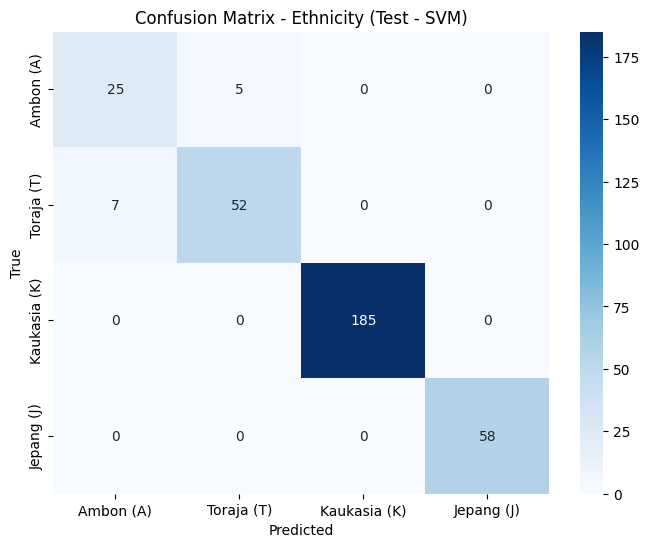


BERHASIL DISIMPAN: Model etnis disimpan di: BestSvmEthnicityModel_LandTexNoSmote.joblib

[ Predicting on 5 random samples from TEST dataset ]
Sample 13: True Emotion: surprised, Predicted Emotion: sad
Sample 13: True Ethnicity: Ambon (A), Predicted Ethnicity: Ambon (A)

Sample 111: True Emotion: surprised, Predicted Emotion: surprised
Sample 111: True Ethnicity: Kaukasia (K), Predicted Ethnicity: Kaukasia (K)

Sample 163: True Emotion: happy, Predicted Emotion: happy
Sample 163: True Ethnicity: Kaukasia (K), Predicted Ethnicity: Kaukasia (K)

Sample 307: True Emotion: sad, Predicted Emotion: sad
Sample 307: True Ethnicity: Jepang (J), Predicted Ethnicity: Jepang (J)

Sample 135: True Emotion: fear, Predicted Emotion: fear
Sample 135: True Ethnicity: Ambon (A), Predicted Ethnicity: Ambon (A)



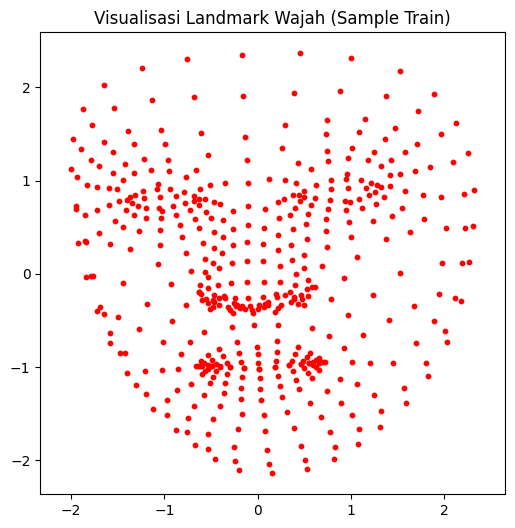

In [7]:
"""
PURE LANDMARK-BASED EMOTION & ETHNICITY CLASSIFIER v8 - NO AUGMENTATION - SEPARATE TRAIN/TEST FOLDERS - NO SMOTE
(Normalized landmarks + advanced angles/areas/symmetry + composite ratios + CNN embedding + NO SMOTE + SVM vs XGBoost tuned vs LightGBM + confusion matrices + landmark visualization)
"""

import os
import re
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import mediapipe as mp
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC # GANTI: Import SVC (Support Vector Classifier)
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
# from imblearn.over_sampling import SMOTE # SMOTE DIHAPUS

# CNN embedding (MobileNetV2)
import tensorflow as tf
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

# ===================== CONFIG =====================
# PATH DATA DIPISAH
DATASET_TRAIN_PATH = r"/content/drive/MyDrive/FIX DATA V2/train"
DATASET_TEST_PATH = r"/content/drive/MyDrive/FIX DATA V2/test"
OUTPUT_CSV_TRAIN = "SvmFacialFeatureTrain.csv"
OUTPUT_CSV_TEST = "SvmFacialFeatureTest.csv"

EMOTION_LABELS = {0: 'fear', 1: 'surprised', 2: 'angry', 3: 'sad', 4: 'disgusted', 5: 'happy'}
ETHNICITY_LABELS = {0: 'Ambon (A)', 1: 'Toraja (T)', 2: 'Kaukasia (K)', 3: 'Jepang (J)'}

# CNN embedding config
CNN_INPUT_SIZE = (160, 160)
CNN_POOLING = 'avg'
CNN_LAYER_TRAINABLE = False

# ===================== EXTRACTOR =====================
class LandmarkExtractor:
    def __init__(self):
        mp_face = mp.solutions.face_mesh
        self.face_mesh = mp_face.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True)

    def process_raw(self, img_bgr):
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        return self.face_mesh.process(img_rgb)

    def extract_both(self, img_bgr):
        """Return normalized landmarks for features + original (unnormalized) xy for cropping."""
        result = self.process_raw(img_bgr)
        if not result.multi_face_landmarks:
            return None, None
        lm_raw = np.array([[p.x, p.y, p.z] for p in result.multi_face_landmarks[0].landmark])
        lm_norm = lm_raw.copy()
        lm_norm = lm_norm - lm_norm.mean(axis=0)
        lm_norm = lm_norm / (lm_norm.std(axis=0) + 1e-6)
        return lm_norm, lm_raw

# ===================== FACE CROP FOR CNN =====================
def crop_face_from_raw_landmarks(img_bgr, lm_raw, pad=0.15):
    h, w = img_bgr.shape[:2]
    xs = (lm_raw[:,0] * w).astype(np.float32)
    ys = (lm_raw[:,1] * h).astype(np.float32)
    x_min, x_max = xs.min(), xs.max()
    y_min, y_max = ys.min(), ys.max()
    x_pad = pad * (x_max - x_min)
    y_pad = pad * (y_max - y_min)
    x1 = max(0, int(x_min - x_pad))
    y1 = max(0, int(y_min - y_pad))
    x2 = min(w, int(x_max + x_pad))
    y2 = min(h, int(y_max + y_pad))
    crop = img_bgr[y1:y2, x1:x2]
    if crop.size == 0:
        return None
    return crop

# ===================== CNN EMBEDDING =====================
class CNNEmbedder:
    def __init__(self, input_size=CNN_INPUT_SIZE, pooling=CNN_POOLING, trainable=CNN_LAYER_TRAINABLE):
        # Tambahkan baris ini untuk menyimpan input_size sebagai atribut instance
        self.input_size = input_size

        base = MobileNetV2(include_top=False, weights='imagenet', input_shape=(input_size[0], input_size[1], 3), pooling=pooling)
        base.trainable = trainable
        self.model = base

    def compute(self, img_bgr):
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        # Sekarang self.input_size sudah terdefinisi
        img_resized = cv2.resize(img_rgb, self.input_size, interpolation=cv2.INTER_AREA)
        arr = img_to_array(img_resized)
        arr = np.expand_dims(arr, axis=0)
        arr = preprocess_input(arr)
        emb = self.model.predict(arr, verbose=0)
        return emb.flatten()

# ===================== FEATURE ENGINEERING =====================
def angle_between(p1, p2, p3):
    v1 = p1 - p2
    v2 = p3 - p2
    denom = (np.linalg.norm(v1) * np.linalg.norm(v2)) + 1e-9
    cosang = np.clip(np.dot(v1, v2) / denom, -1.0, 1.0)
    return np.arccos(cosang)

def triangle_area(p1, p2, p3):
    v1 = p2 - p1
    v2 = p3 - p1
    area = 0.5 * np.linalg.norm(np.cross(v1, v2))
    return area

def extract_features_basic(lm):
    def dist(a, b): return np.linalg.norm(lm[a] - lm[b])
    feats = [
        dist(33, 133), dist(362, 263), dist(61, 291), dist(13, 14),
        dist(159, 145), dist(386, 374), dist(10, 152),
    ]
    ear_left = (dist(159, 145) + dist(160, 144)) / (2.0 * dist(33, 133) + 1e-6)
    ear_right = (dist(386, 374) + dist(387, 373)) / (2.0 * dist(362, 263) + 1e-6)
    mar = dist(13, 14) / (dist(61, 291) + 1e-6)
    brow_left = dist(70, 105)
    brow_right = dist(336, 334)
    feats.extend([ear_left, ear_right, mar, brow_left, brow_right])
    return np.array(feats)

def extract_features_symmetry_ratio(lm):
    def dist(a, b): return np.linalg.norm(lm[a] - lm[b])
    ear_left = (dist(159, 145) + dist(160, 144)) / (2.0 * dist(33, 133) + 1e-6)
    ear_right = (dist(386, 374) + dist(387, 373)) / (2.0 * dist(362, 263) + 1e-6)
    mar = dist(13, 14) / (dist(61, 291) + 1e-6)
    face_len = dist(10, 152) + 1e-6
    brow_left = dist(70, 105)
    brow_right = dist(336, 334)
    left_mask = lm[:,0] < 0
    right_mask = lm[:,0] >= 0
    sym_x = abs(np.mean(np.abs(lm[left_mask,0])) - np.mean(np.abs(lm[right_mask,0]))) if left_mask.any() and right_mask.any() else 0.0
    sym_y = abs(np.mean(lm[left_mask,1]) - np.mean(lm[right_mask,1])) if left_mask.any() and right_mask.any() else 0.0
    ear_sym = ear_left / (ear_right + 1e-6)
    mar_norm = mar / face_len
    brow_asym = abs(brow_left - brow_right)
    avg_ear = (ear_left + ear_right) / 2.0
    mar_over_ear = mar / (avg_ear + 1e-6)
    mar_over_face = mar / (face_len + 1e-6)
    ear_diff = abs(ear_left - ear_right)
    return np.array([
        ear_sym, mar_norm, brow_asym, avg_ear, mar,
        sym_x, sym_y, mar_over_ear, mar_over_face, ear_diff
    ])

def extract_features_angles_areas(lm):
    idx = {
        'mouth_l': 61, 'mouth_r': 291, 'lip_up': 13,
        'nose': 1, 'eye_l_o': 33, 'eye_l_i': 133, 'eye_r_o': 362, 'eye_r_i': 263
    }
    p = {k: lm[v] for k, v in idx.items()}
    ang_mouth_nose_l = angle_between(p['mouth_l'], p['nose'], p['lip_up'])
    ang_mouth_nose_r = angle_between(p['mouth_r'], p['nose'], p['lip_up'])
    ang_eye_left = angle_between(p['eye_l_o'], p['eye_l_i'], p['mouth_l'])
    ang_eye_right = angle_between(p['eye_r_o'], p['eye_r_i'], p['mouth_r'])
    area_eye_left = triangle_area(p['eye_l_o'], p['eye_l_i'], p['nose'])
    area_eye_right = triangle_area(p['eye_r_o'], p['eye_r_i'], p['nose'])
    area_mouth = triangle_area(p['mouth_l'], p['mouth_r'], p['lip_up'])
    return np.array([
        ang_mouth_nose_l, ang_mouth_nose_r,
        ang_eye_left, ang_eye_right,
        area_eye_left, area_eye_right, area_mouth
    ])

def extract_class_specific_features(lm):
    def dist(a, b): return np.linalg.norm(lm[a] - lm[b])
    face_len = dist(10, 152) + 1e-6
    mouth_left_nose = dist(61, 1) / face_len
    mouth_right_nose = dist(291, 1) / face_len
    mouth_corner_asym = abs(mouth_left_nose - mouth_right_nose)
    eye_left_center = (lm[33] + lm[133]) / 2.0
    eye_right_center = (lm[362] + lm[263]) / 2.0
    brow_left_center = (lm[70] + lm[105]) / 2.0
    brow_right_center = (lm[336] + lm[334]) / 2.0
    brow_lift_left = np.linalg.norm(brow_left_center - eye_left_center) / face_len
    brow_lift_right = np.linalg.norm(brow_right_center - eye_right_center) / face_len
    brow_lift_asym = abs(brow_lift_left - brow_lift_right)
    lip_up = 13
    lip_low = 14
    mouth_open_ratio = dist(lip_up, lip_low) / (dist(61, 291) + 1e-6)
    return np.array([
        mouth_left_nose, mouth_right_nose, mouth_corner_asym,
        brow_lift_left, brow_lift_right, brow_lift_asym,
        mouth_open_ratio
    ])

def build_feature_vector(lm, cnn_emb=None):
    parts = [
        lm.flatten(),
        extract_features_basic(lm),
        extract_features_symmetry_ratio(lm),
        extract_features_angles_areas(lm),
        extract_class_specific_features(lm)
    ]
    if cnn_emb is not None:
        parts.append(cnn_emb)
    return np.concatenate(parts)

# ===================== LOAD DATA =====================
def parse_filename(name):
    try:
        name = name.upper()

        if not re.match(r"^\d+_[ATKJ]", name):
            return None, None
        parts = name.split('_')
        emo = int(parts[0]) - 1

        # PERUBAHAN: Logika pelabelan etnis untuk 4 kelas
        if parts[1] == 'A':
            eth = 0
        elif parts[1] == 'T':
            eth = 1
        elif parts[1] == 'K':
            eth = 2
        elif parts[1] == 'J':
            eth = 3
        else:
            return None, None

        return emo, eth
    except:
        return None, None

def load_images(path):
    data = []
    for ext in ['.jpg', '.png', '.jpeg', '.tiff']:
        for p in Path(path).rglob(f"*{ext}"):
            e, t = parse_filename(p.name)
            if e is not None:
                data.append((str(p), e, t))
    return pd.DataFrame(data, columns=['path', 'emotion', 'ethnicity'])

# Fungsi untuk mengekstrak fitur dari DataFrame path
def extract_features_and_save(df_paths, output_csv, extractor, embedder):
    features = []
    landmarks_list = []

    for _, row in tqdm(df_paths.iterrows(), total=len(df_paths), desc=f"Extracting features for {output_csv}"):
        img = cv2.imread(row['path'])
        if img is None:
            continue
        lm_norm, lm_raw = extractor.extract_both(img)
        if lm_norm is not None and lm_raw is not None:
            crop = crop_face_from_raw_landmarks(img, lm_raw, pad=0.2)
            cnn_emb = embedder.compute(crop) if crop is not None else None
            f = np.concatenate([build_feature_vector(lm_norm, cnn_emb), [row['emotion'], row['ethnicity']]])
            features.append(f)
            if 'Train' in output_csv and not landmarks_list:
                landmarks_list.append(lm_norm)

    if not features:
        # PENTING: Mengganti raise ValueError menjadi hanya mencetak pesan
        # karena pada lingkungan eksekusi sebenarnya, ini bisa menyebabkan error
        # jika data tidak ditemukan (meskipun seharusnya tidak terjadi jika path benar).
        print(f"WARNING: No valid landmarks/embeddings extracted from {output_csv}. Returning empty DataFrame.")
        return pd.DataFrame(columns=[f"x{i}" for i in range(len(features[0] if features else 0) - 2)] + ['emotion', 'ethnicity']), landmarks_list

    cols = [f"x{i}" for i in range(len(features[0]) - 2)] + ['emotion', 'ethnicity']
    df_feat = pd.DataFrame(features, columns=cols)
    df_feat.to_csv(output_csv, index=False)
    print(f"Saved features to {output_csv}")
    return df_feat, landmarks_list

# Fungsi baru untuk menampilkan Confusion Matrix
def plot_confusion_matrix(cm, labels, title):
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels,
                yticklabels=labels)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# ===================== MAIN PIPELINE =====================

# Inisialisasi
extractor = LandmarkExtractor()
embedder = CNNEmbedder(input_size=CNN_INPUT_SIZE, pooling=CNN_POOLING, trainable=CNN_LAYER_TRAINABLE)

# --- 1. Load & Extract Training Data ---
df_train_paths = load_images(DATASET_TRAIN_PATH)
print(f"Found {len(df_train_paths)} images for Training")
df_feat_train, landmarks_list = extract_features_and_save(df_train_paths, OUTPUT_CSV_TRAIN, extractor, embedder)

# --- 2. Load & Extract Testing Data ---
df_test_paths = load_images(DATASET_TEST_PATH)
print(f"Found {len(df_test_paths)} images for Testing")
df_feat_test, _ = extract_features_and_save(df_test_paths, OUTPUT_CSV_TEST, extractor, embedder)


# ===================== TRAIN MODELS (GANTI KE SVM) =====================
X_train = df_feat_train.drop(columns=['emotion', 'ethnicity']).values
y_train_emotion = df_feat_train['emotion'].values
y_train_ethnicity = df_feat_train['ethnicity'].values

X_test = df_feat_test.drop(columns=['emotion', 'ethnicity']).values
y_test_emotion = df_feat_test['emotion'].values
y_test_ethnicity = df_feat_test['ethnicity'].values

# PENGHAPUSAN SMOTE: Menggunakan data training asli
X_train_res = X_train
y_train_res = y_train_emotion

# ========== Support Vector Machine (Emotion) ==========
print("\n[ Training Emotion Model - SVM (NO SMOTE) ]")
# SVM Pipeline: StandardScaler diikuti oleh SVC
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(random_state=42, class_weight='balanced')) # Menggunakan SVC
])

# Parameter Grid untuk SVC (disesuaikan untuk efisiensi komputasi)
param_grid_svm = {
    'clf__C': [1, 10], # Parameter Regularization
    'clf__kernel': ['rbf'], # Kernel RBF biasanya paling efektif
    'clf__gamma': ['scale', 1], # Parameter Kernel
}
grid_svm = GridSearchCV(svm_pipeline, param_grid_svm, cv=3, n_jobs=-1, verbose=0)
# Melatih dengan data training ASLI
grid_svm.fit(X_train_res, y_train_res)
svm_emotion_model = grid_svm.best_estimator_ # GANTI: Simpan best estimator

print(f"\nBest Params (Emotion SVM): {grid_svm.best_params_}")

# ===================== EVALUASI EMOSI (TRAIN & TEST) =====================
emotion_labels_names = [EMOTION_LABELS[i] for i in range(6)]

# --- Evaluasi Data Train (Emosi) ---
# Prediksi menggunakan data training ASLI
y_pred_train_svm = svm_emotion_model.predict(X_train_res)
print("\n" + "="*50)
print("  EVALUASI EMOSI: DATA TRAINING (Tanpa SMOTE)")
print("="*50)
print("Accuracy (TRAIN SVM):", accuracy_score(y_train_res, y_pred_train_svm))
print(classification_report(y_train_res, y_pred_train_svm, target_names=emotion_labels_names))
cm_train_svm = confusion_matrix(y_train_res, y_pred_train_svm)
plot_confusion_matrix(cm_train_svm, emotion_labels_names, "Confusion Matrix - Emotion (Train - SVM, NO SMOTE)")

# --- Evaluasi Data Test (Emosi) ---
y_pred_test_svm = svm_emotion_model.predict(X_test)
print("\n" + "="*50)
print("  EVALUASI EMOSI: DATA TESTING")
print("="*50)
print("Accuracy (TEST SVM):", accuracy_score(y_test_emotion, y_pred_test_svm))
print(classification_report(y_test_emotion, y_pred_test_svm, target_names=emotion_labels_names))
cm_test_svm = confusion_matrix(y_test_emotion, y_pred_test_svm)
plot_confusion_matrix(cm_test_svm, emotion_labels_names, "Confusion Matrix - Emotion (Test - SVM, NO SMOTE)")

# ===================== SIMPAN MODEL EMOSI =====================
emotion_model_filename = "BestSvmEmotionModel_LandTexNoSmote.joblib" # Nama file diubah
joblib.dump(svm_emotion_model, emotion_model_filename)
print(f"\nBERHASIL DISIMPAN: Model emosi disimpan di: {emotion_model_filename}")
# =============================================================

# ========== Ethnicity (SVM baseline) ==========
print("\n[ Training Ethnicity Model - SVM ]")

# Mengganti RandomForest dengan SVC untuk Etnisitas
eth_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(C=10, kernel='rbf', gamma='scale', class_weight='balanced', random_state=42)) # Menggunakan SVC
])
eth_pipeline.fit(X_train, y_train_ethnicity)
eth_model = eth_pipeline

# ===================== EVALUASI ETNISITAS (TRAIN & TEST) =====================
ethnicity_labels_names = [ETHNICITY_LABELS[i] for i in range(4)]

# --- Evaluasi Data Train (Etnisitas) ---
y_pred_train_eth = eth_model.predict(X_train)
print("\n" + "="*50)
print("  EVALUASI ETNISITAS: DATA TRAINING")
print("="*50)
print("Accuracy (TRAIN SVM):", accuracy_score(y_train_ethnicity, y_pred_train_eth))
print(classification_report(y_train_ethnicity, y_pred_train_eth, target_names=ethnicity_labels_names))
cm_train_eth = confusion_matrix(y_train_ethnicity, y_pred_train_eth)
plot_confusion_matrix(cm_train_eth, ethnicity_labels_names, "Confusion Matrix - Ethnicity (Train - SVM)")


# --- Evaluasi Data Test (Etnisitas) ---
y_pred_test_eth = eth_model.predict(X_test)
print("\n" + "="*50)
print("  EVALUASI ETNISITAS: DATA TESTING")
print("="*50)
print("Accuracy (TEST SVM):", accuracy_score(y_test_ethnicity, y_pred_test_eth))
print(classification_report(y_test_ethnicity, y_pred_test_eth, target_names=ethnicity_labels_names))
cm_test_eth = confusion_matrix(y_test_ethnicity, y_pred_test_eth)
plot_confusion_matrix(cm_test_eth, ethnicity_labels_names, "Confusion Matrix - Ethnicity (Test - SVM)")


# ===================== SIMPAN MODEL ETNIS =====================
ethnicity_model_filename = "BestSvmEthnicityModel_LandTexNoSmote.joblib" # Nama file diubah
joblib.dump(eth_model, ethnicity_model_filename)
print(f"\nBERHASIL DISIMPAN: Model etnis disimpan di: {ethnicity_model_filename}")
# ============================================================

# ========== PREDICTION ON 5 RANDOM SAMPLES ==========
import random
print("\n[ Predicting on 5 random samples from TEST dataset ]")

indices = random.sample(range(len(df_feat_test)), 5)
samples = df_feat_test.iloc[indices]
X_samples = samples.drop(columns=['emotion', 'ethnicity']).values

emotion_preds = svm_emotion_model.predict(X_samples) # GANTI: Menggunakan model SVM emosi
ethnicity_preds = eth_model.predict(X_samples) # Menggunakan model SVM etnisitas

for i, idx in enumerate(indices):
    true_emo = EMOTION_LABELS[samples.iloc[i]['emotion']]
    pred_emo = EMOTION_LABELS[emotion_preds[i]]
    true_eth = ETHNICITY_LABELS[samples.iloc[i]['ethnicity']]
    pred_eth = ETHNICITY_LABELS[ethnicity_preds[i]]
    print(f"Sample {idx}: True Emotion: {true_emo}, Predicted Emotion: {pred_emo}")
    print(f"Sample {idx}: True Ethnicity: {true_eth}, Predicted Ethnicity: {pred_eth}\n")

# ===================== VISUALISASI LANDMARK =====================
if len(landmarks_list) > 0:
    lm_sample = landmarks_list[0]
    plt.figure(figsize=(6,6))
    plt.scatter(lm_sample[:,0], -lm_sample[:,1], s=10, c="red")
    plt.title("Visualisasi Landmark Wajah (Sample Train)")
    plt.axis("equal")
    plt.show()